In this notebook, we use a simple example to show how to use `cuquantum.CircuitToEinsum` 
to take a `qiskit.QuantumCircuit` instance and run basic quantum circuit simulation using cuTensorNet.

In [1]:
import cupy as cp
import numpy as np
import qiskit
from qiskit.circuit.random import random_circuit

from cuquantum import contract
from cuquantum import CircuitToEinsum

## Generate a random quantum circuit

The generated `circuit` object is of type `qiskit.QuantumCircuit`.

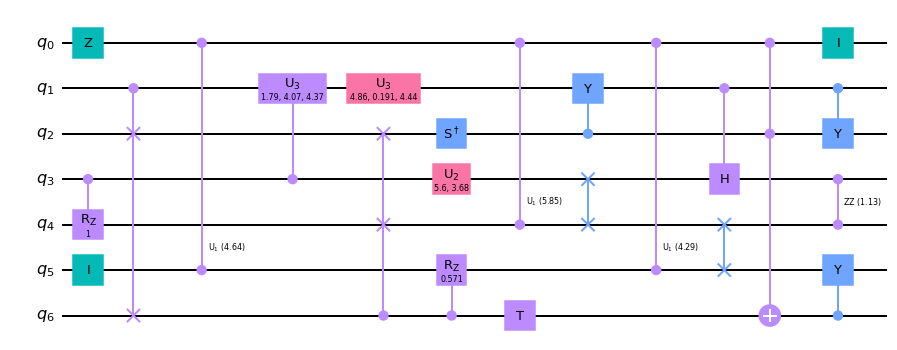

In [2]:
num_qubits = 7
depth = 6

circuit = random_circuit(num_qubits, depth, seed=3)
circuit.draw(output='mpl')

## Construct the converter object targeting double precision

In this example, we generate the tensor operands as CuPy arrays (by setting `backend=cupy`).

In [3]:
myconverter = CircuitToEinsum(circuit, dtype='complex128', backend=cp)

### compute state vector $| \psi\rangle$

Different from the notation in `qiskit`, the indices of the output tensor is consistent with `qiskit.QuantumCircuit.qubits`

In [4]:
expression, operands = myconverter.state_vector()
sv = contract(expression, *operands)
print(f'wavefunction coefficient shape: {sv.shape}')
print(type(operands[0]))
print(type(sv))

# check if the computed statevector is correct
circuit.save_statevector()
simulator = qiskit.Aer.get_backend('aer_simulator_statevector')
circ = qiskit.transpile(circuit, simulator)
result = simulator.run(circ).result()
sv_qiskit = np.asarray(result.get_statevector()).reshape([2]*num_qubits)
sv_qiskit = sv_qiskit.transpose(range(num_qubits-1, -1, -1))
print(f"is sv in agreement?", cp.allclose(sv, sv_qiskit))

wavefunction coefficient shape: (2, 2, 2, 2, 2, 2, 2)
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
is sv in agreement? True


### calculate bitstring amplitude $\langle b| \psi\rangle$

In [5]:
bitstring = '0000000'

expression, operands = myconverter.amplitude(bitstring)
print(f'einsum expression:\n{expression} \n')

amplitude = contract(expression, *operands)
probability = abs(amplitude) ** 2
print(f'for bitstring {bitstring}, amplitude: {amplitude}, probability: {probability}\n')

amplitude_from_sv = sv[0,0,0,0,0,0,0]
amp_diff = abs(amplitude-amplitude_from_sv)
print(f'difference from state vector {amp_diff}')

einsum expression:
a,b,c,d,e,f,g,ha,ijed,kf,lmkh,nopgcb,qrpj,sq,tr,uvwion,xyum,zv,ABsz,CDxt,EFDA,GHlw,IJGy,KLIC,MNEL,OH,PQROJB,SQ,TURF,VWKP,S,U,T,M,N,V,W-> 

for bitstring 0000000, amplitude: (-0.4516204880327095+0.2871796749721902j), probability: 0.2864332309280355

difference from state vector 0.0


### compute reduced density matrix $\rho\left( {\bar{p}|b_{\bar{f}}} \right) = Tr_{\bar{p}}\langle b_{\bar{f}}|\psi_{\bar{f}\cup\bar{p}}\rangle \langle \psi_{\bar{f}\cup\bar{p}}\rangle| b_{\bar{f}} \rangle$

In this example, we construct the reduced density matrix of qubits 0 & 1 (so the returned RDM should have $2^2\times2^2=16$ elements), with qubits 3 & 4 fixed at state 0

In [6]:
where = circuit.qubits[:2]
fixed = {circuit.qubits[3]: '0',
         circuit.qubits[4]: '0'}

# we set lightcone=True to reduce the size of the tensor network
expression, operands = myconverter.reduced_density_matrix(where, fixed=fixed, lightcone=True)
rdm = contract(expression, *operands)
print(f'shape of reduced density matrix: {rdm.shape}')

# check if the computed RDM is correct
rdm_from_sv = contract('abefg, ABefg->abAB', sv[:, :, :, 0, 0], sv[:, :, :, 0, 0].conj())
print(f"is rdm in agreement?", cp.allclose(rdm, rdm_from_sv))

shape of reduced density matrix: (2, 2, 2, 2)
is rdm in agreement? True
